# Group members

Name: Tran Thai Duc Hieu  
4-digit code: 8f95  
Email: t.tran@oth-aw.de  

Name: Sarvarbek Akhmedov  
4-digit code: eda4  
Email: s.akhmedov@oth-aw.de  



# 1. Data recording  

- **Raw IMU data:** `source/data_record/data_main.csv`
- **Arduino ino code:** `source/data_record/record/record.ino`
- **Python receiver code:** `source/data_record/to_csv.ipynb`

## Experiment description

- **Place:** Digital Campus ground floor
- **Real map size:** 12m x 6.6m
- **Arduino board placement:** fixed in the right pocket of the pants, with y-axis point toward the sky
- **Track length:** approximately 72m

<img src="../note/experiment.jpg" alt="Experiment" width="300"/> </br>


- Magnetometor sensor was not recorded because we saw a significant drop in the sampling rate when Magnetometer was included  
- Due to some personal reasons, we don't use BLE device in this experiment
- The data using in this project is the path described in the sketch above (`../note/experiment.jpg`)
- The original recorded path is longer than than the path we described in this project, but we decided to only use approximately first 72m of the original path

<img src="map_DC.png" alt="Pixel map" width="600"/>

- Pixel map that shows real path

- The video below shows the our recording procedure:

<video width="600" controls>
  <source src="../note/vid1.mp4" type="video/mp4">
</video>

# 2. Sensor processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

FILE_PATH = 'data_record/data_main.csv'

def loadData(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)    
    return data


In [2]:
walking_data = loadData(FILE_PATH)
walking_data = walking_data[:3430, :]  
walking_data[:, 0] = walking_data[:, 0] - walking_data[0, 0]

timestamp = walking_data[:,0]

# Calculate the time difference between each sample
d = timestamp[1:] - timestamp[:-1]
time_diff = pd.DataFrame(d, columns=['time_diff'])
time_diff.describe()

,time_diff
count,3429.000000
mean,20.350540
std,3.402014
min,11.000000
25%,17.000000
50%,21.000000
75%,21.000000
max,37.000000


In [3]:
visualization_data = walking_data[:,:-2]
df_walking = pd.DataFrame(visualization_data, columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z',])
df_walking['acc_magnitude'] = np.sqrt(df_walking['acc_x']**2 + df_walking['acc_y']**2 + df_walking['acc_z']**2)
df_walking['gyro_magnitude'] = np.sqrt(df_walking['gyro_x']**2 + df_walking['gyro_y']**2 + df_walking['gyro_z']**2)

df_walking.describe()


,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_magnitude,gyro_magnitude
count,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000,3430.000000
mean,34585.961808,-0.903525,-0.320770,0.150536,10.791181,0.753615,1.028128,1.035865,91.293529
std,20205.533503,0.308134,0.277491,0.231621,62.296492,41.824062,71.419807,0.307332,50.120494
min,0.000000,-2.730000,-1.590000,-0.880000,-239.010000,-132.810000,-168.030000,0.190526,0.189737
25%,16610.000000,-1.000000,-0.460000,0.020000,-27.025000,-29.170000,-49.260000,0.906270,54.209916
50%,34413.500000,-0.910000,-0.280000,0.110000,8.420000,-7.390000,-13.640000,0.987396,78.741269
75%,52110.750000,-0.740000,-0.170000,0.250000,36.485000,28.690000,48.815000,1.147290,130.949623
max,69782.000000,0.000000,0.740000,1.020000,278.560000,119.260000,179.440000,2.806528,288.468189


In [4]:
np.abs(df_walking['gyro_y'].to_numpy()).mean()

33.53291545189504

Unique sampling intervals:
 [11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 33. 35. 36. 37.]
Counts of unique sampling intervals:
 [   2   24   40   29   61  138  586  153  183  331 1070  212  115   79
   54  208   61   21   12   13   12   13    5    2    4    1]
---------------------------------
Intervals values that appear more than 100 times:
 [16. 17. 18. 19. 20. 21. 22. 23. 26.]
Counts of most frequent sampling intervals:
 [ 138  586  153  183  331 1070  212  115  208]


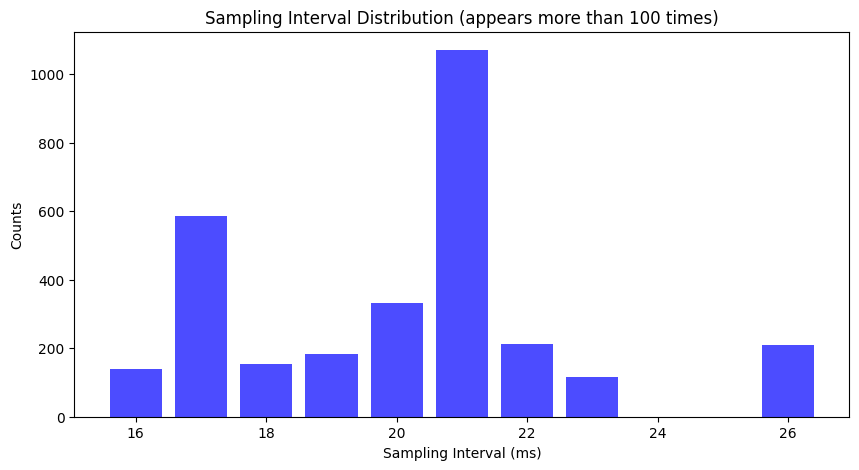

In [5]:
values, counts = np.unique(d, return_counts=True)
print('Unique sampling intervals:\n',values)
print('Counts of unique sampling intervals:\n',counts)
print('---------------------------------')

rate_significant = values[counts > 100]
counts_significant = counts[counts > 100]
print('Intervals values that appear more than 100 times:\n', rate_significant)    
print('Counts of most frequent sampling intervals:\n', counts_significant)

# Plot the sampling intervals   
plt.figure(figsize=(10,5))
plt.bar(rate_significant, counts_significant, color='blue', alpha=0.7)
plt.xlabel('Sampling Interval (ms)')
plt.ylabel('Counts')
plt.title('Sampling Interval Distribution (appears more than 100 times)')
plt.show()



In [6]:
most_frequent_interval_mean = np.mean(rate_significant)
print('Sampling rate (Hz) = 1 / sampling_interval(s)')
print(f'Sampling rate (Hz) = 1 / ({most_frequent_interval_mean} / 1000)')
print(f'Sampling rate (Hz) = {1000 / most_frequent_interval_mean:.2f} Hz')

Sampling rate (Hz) = 1 / sampling_interval(s)
Sampling rate (Hz) = 1 / (20.22222222222222 / 1000)
Sampling rate (Hz) = 49.45 Hz


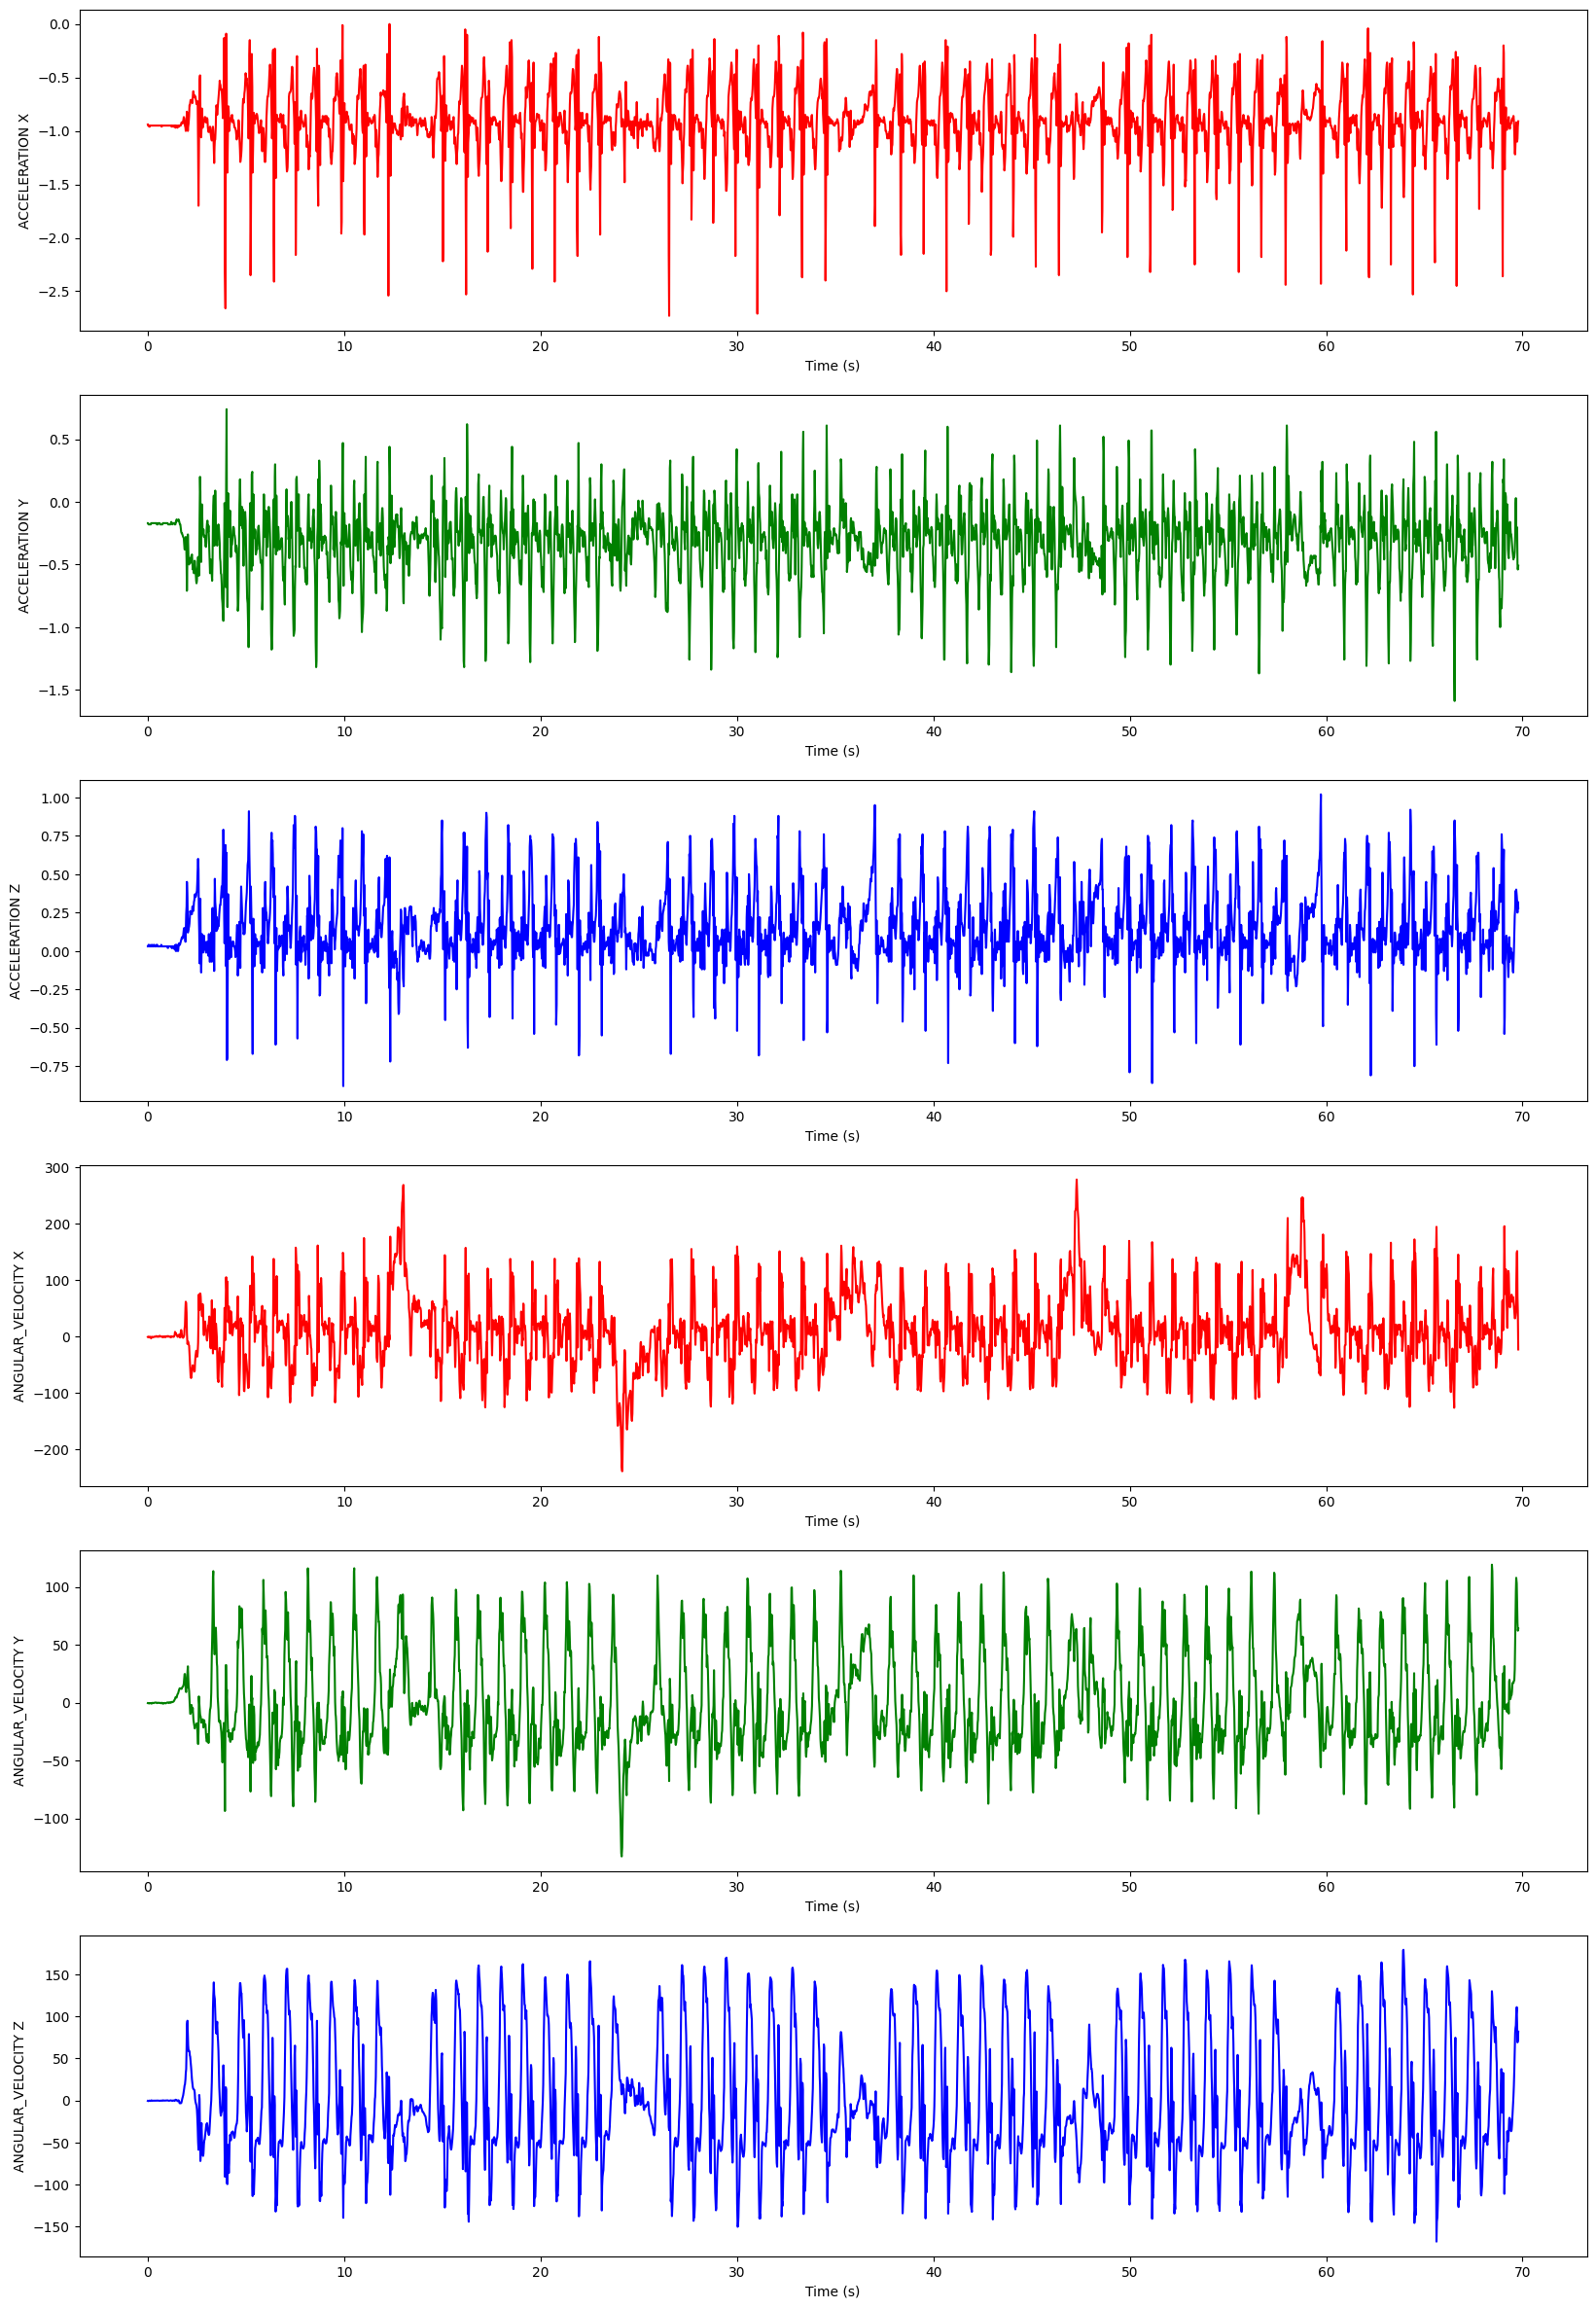

In [7]:
def plotData(data):
    # Desciption: 
    # Plot only the Magnitude of the data

    time = data[:, 0] / 1000  # Convert milliseconds to seconds
    acceleration = data[:, 1:4]  
    angular_velocity = data[:, 4:7]  

    a_abs = np.sqrt(acceleration[:, 0]**2 + acceleration[:, 1]**2 + acceleration[:, 2]**2)
    w_abs = np.sqrt(angular_velocity[:, 0]**2 + angular_velocity[:, 1]**2 + angular_velocity[:, 2]**2)

    # Plot the data
    plt.figure(figsize=(15, 10))

    # Plot acceleration
    plt.subplot(3, 1, 1)
    plt.plot(time, a_abs)
    plt.title('Acceleration Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (G)')

    # Plot angular velocity
    plt.subplot(3, 1, 2)
    plt.plot(time, w_abs)
    plt.title('Angular Velocity Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')

    plt.tight_layout()
    plt.show()

def plotData2(data):
    # Desciption: 
    # Plot all three axes of acceleration, angular velocity
    
    time = data[:, 0] / 1000  # Convert to seconds

    data_dict = {
        'acceleration': data[:, 1:4],
        'angular_velocity': data[:, 4:7],
    }

    plt.figure(figsize=(20, 30))

    row = 1
    for key in ['acceleration', 'angular_velocity']:
        for i, data_axis in enumerate(['x', 'y', 'z']):
            plt.subplot(6, 1, row)
            plt.plot(time, data_dict[key][:, i], color='r' if i == 0 else 'g' if i == 1 else 'b')
            plt.ylabel(key.upper() + ' ' + data_axis.upper())
            plt.xlabel('Time (s)')
            row = row + 1

    plt.show() 

plotData2(walking_data)

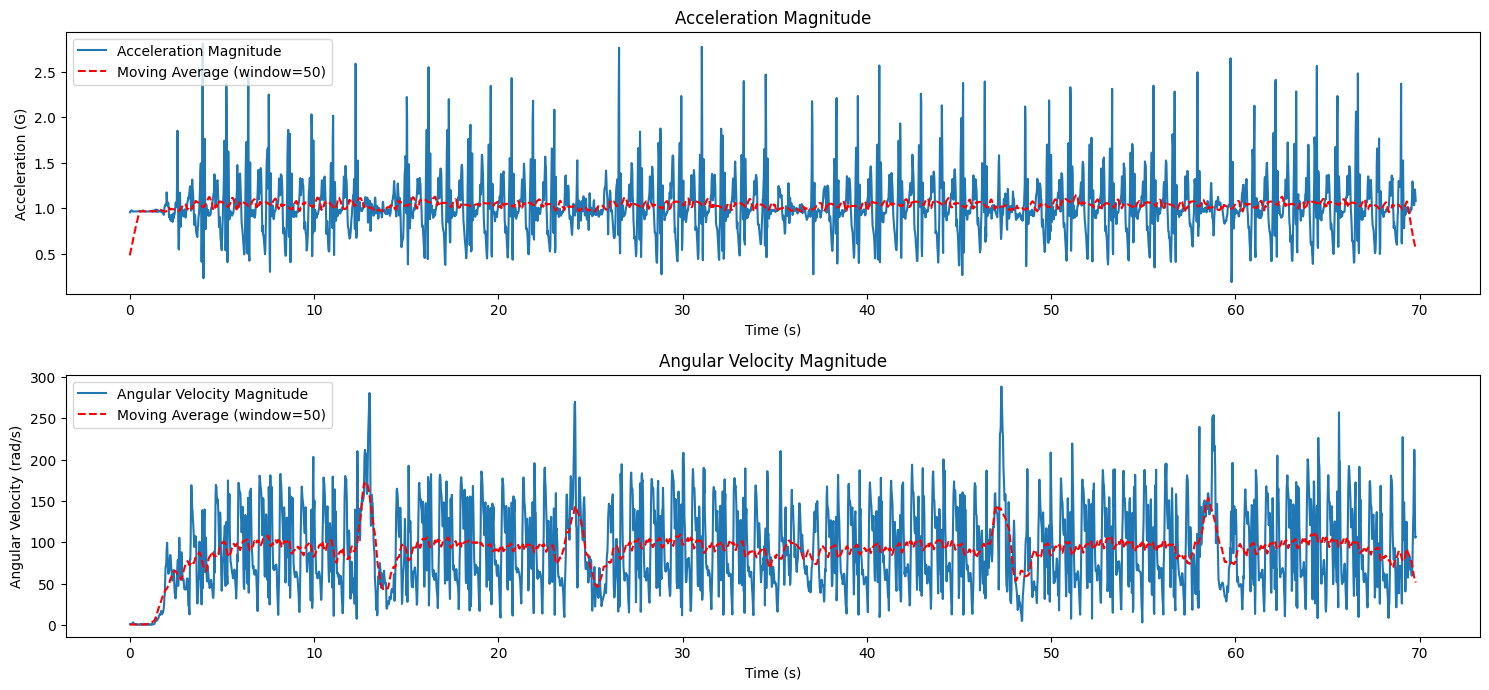

In [8]:
def plotDataMA(data, window_size=20):
    time = data[:, 0] / 1000  # Convert milliseconds to seconds
    acceleration = data[:, 1:4]
    angular_velocity = data[:, 4:7]

    # Calculate magnitude
    a_abs = np.sqrt(np.sum(acceleration**2, axis=1))
    w_abs = np.sqrt(np.sum(angular_velocity**2, axis=1))

    # Moving average
    def moving_average(x, w):
        return np.convolve(x, np.ones(w)/w, mode='same')

    a_avg = moving_average(a_abs, window_size)
    w_avg = moving_average(w_abs, window_size)

    plt.figure(figsize=(15, 10))

    # Acceleration
    plt.subplot(3, 1, 1)
    plt.plot(time, a_abs, label='Acceleration Magnitude')
    plt.plot(time, a_avg, 'r--', label=f'Moving Average (window={window_size})')
    plt.title('Acceleration Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (G)')
    plt.legend()

    # Angular velocity
    plt.subplot(3, 1, 2)
    plt.plot(time, w_abs, label='Angular Velocity Magnitude')
    plt.plot(time, w_avg, 'r--', label=f'Moving Average (window={window_size})')
    plt.title('Angular Velocity Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')
    plt.legend()

    plt.tight_layout()
    plt.show()

plotDataMA(walking_data, window_size=50)

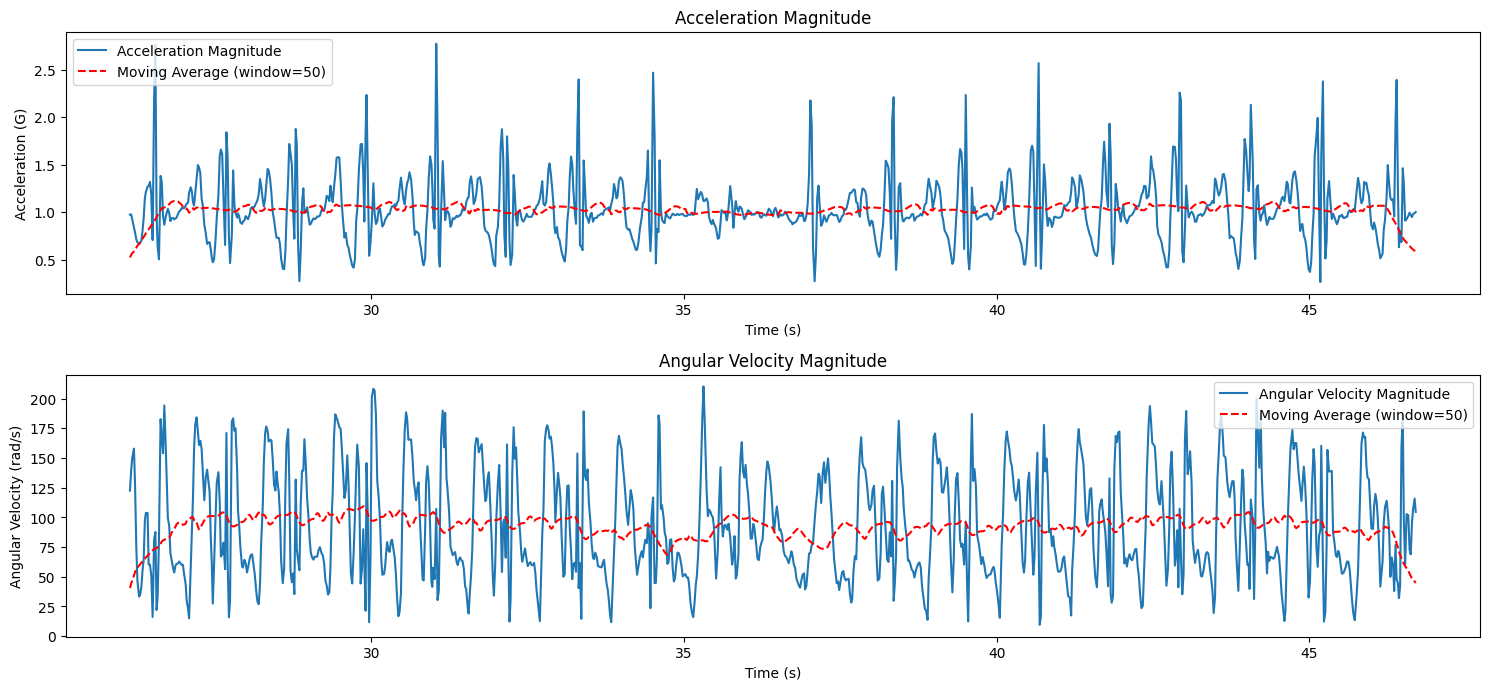

In [9]:
plotDataMA(walking_data[1311:2307], window_size=50)


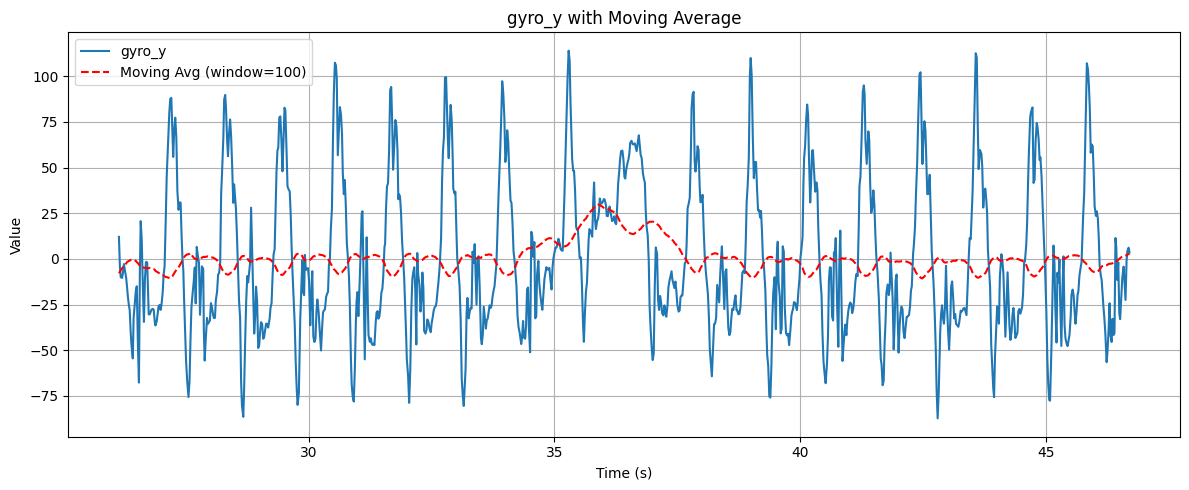

In [10]:
def plotOneMA(data, column_name='accel_x', window_size=20):
    # Mapping from column name to index
    col_index_map = {
        'accel_x': 1,
        'accel_y': 2,
        'accel_z': 3,
        'gyro_x': 4,
        'gyro_y': 5,
        'gyro_z': 6
    }

    if column_name not in col_index_map:
        raise ValueError("Invalid column name. Must be one of: 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z'.")

    # Get time and selected signal
    time = data[:, 0] / 1000  # milliseconds to seconds
    col_data = data[:, col_index_map[column_name]]

    # Compute moving average
    def moving_average(x, w):
        return np.convolve(x, np.ones(w)/w, mode='same')

    col_avg = moving_average(col_data, window_size)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(time, col_data, label=column_name)
    plt.plot(time, col_avg, 'r--', label=f'Moving Avg (window={window_size})')
    plt.title(f'{column_name} with Moving Average')
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plotOneMA(walking_data[1311:2307], column_name='gyro_y', window_size=100)

# 3. Implementation

## Idea
**For Distance/Velocity estimation:**
- We detect the number of steps based on Peak detection algorithm to count the number of step from Acceleration data
- We use a fixed approximation **STEP LENGTH of 0.58m** for every step to estimate the position   

**For Heading estimation:**   
- We use Gyroscope y-axis to estimate the change in direction at beginning of each step



## Hard turn detection (detect 180 degree turn)

- Because the 180-degree-turn is very difficult to estimate using only Gyroscope y-axis data, we implement this method instead to detect a 180-degree-turn

- To recognize the pattern for this hard-turn, we need to calculate the Moving Average of `gyro_y`
- Window-size = 50 **because** sampling rate is nearly 50 Hz (50 samples / second) and 1 human step takes around 1 second

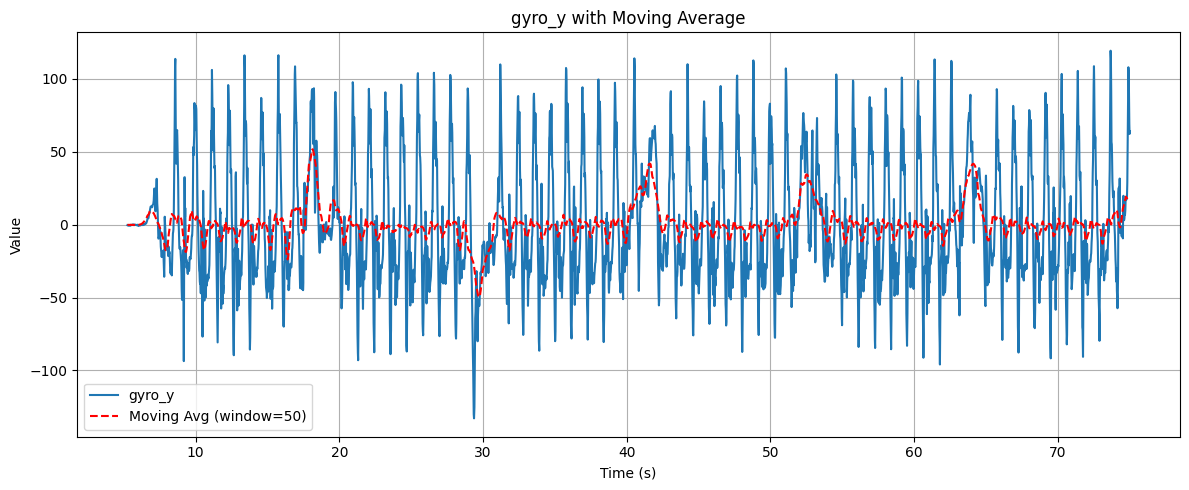

In [11]:
# === Load data ===
FILE_PATH = 'data_record/data_main.csv'

df = pd.read_csv(FILE_PATH)
df = df.head(3430)

df['acc_magnitude'] = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
df['gyro_magnitude'] = np.sqrt(df['gyro_x']**2 + df['gyro_y']**2 + df['gyro_z']**2)

# === Làm mượt bằng trung bình trượt (tùy chọn) ===
window_size = 50
df['gyro_smooth'] = df['gyro_y'].rolling(
    window=window_size, center=True).mean()
    
walking_data = df.to_numpy()
plotOneMA(walking_data, column_name='gyro_y', window_size=50)

Total turning periods detected: 5


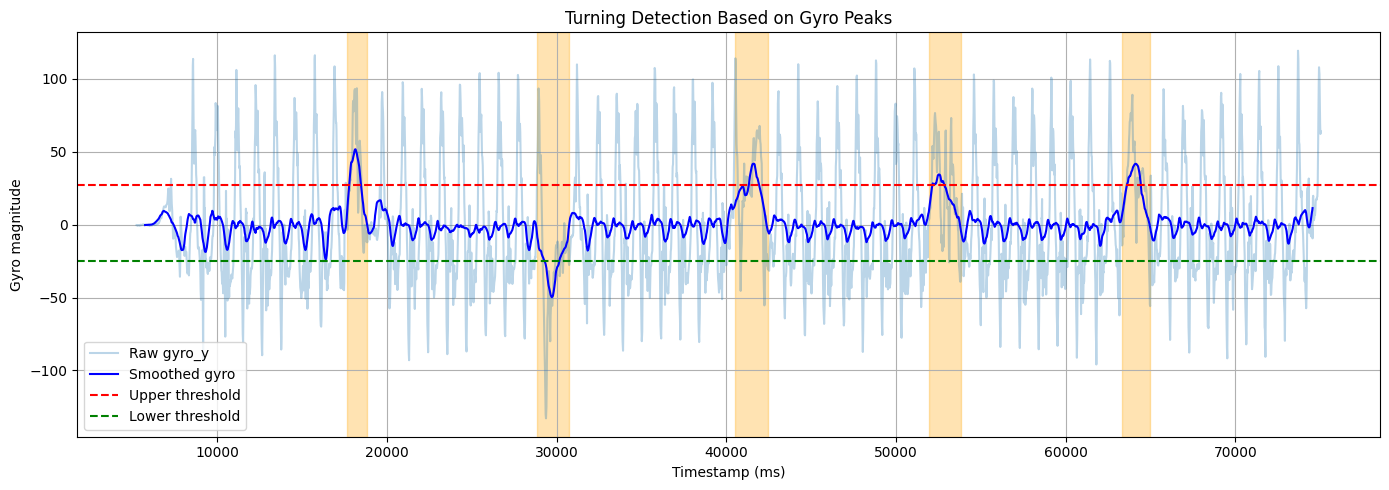

In [ ]:


UPPER_THRESHOLD = 27
LOWER_THRESHOLD = -25
STEP_DELAY_MS = 2000
last_step_time = -np.inf
step_count = 0
turning_period = []

last_turn_index = -1
for i in range(1, len(df) - 20):
    g_prev = df['gyro_smooth'].iloc[i - 3]
    g_curr = df['gyro_smooth'].iloc[i]
    g_next = df['gyro_smooth'].iloc[i + 3]
    t = df['timestamp'].iloc[i]

    if (t - last_step_time) > STEP_DELAY_MS:
        if (g_curr > UPPER_THRESHOLD and (g_prev < g_curr and g_curr > g_next)):
            left = i-1
            right = i + 1
            while df['gyro_smooth'].iloc[left] > 15:
                left -= 5
            while df['gyro_smooth'].iloc[right] > 0:
                right += 5

            turning_period.append((left, right))
            last_step_time = t


        elif (g_curr < LOWER_THRESHOLD and (g_prev > g_curr and g_curr < g_next)):
            left = i-1
            right = i + 1
            while df['gyro_smooth'].iloc[left] < -15:
                left -= 5
            while df['gyro_smooth'].iloc[right] < 0:
                right += 5
                
            turning_period.append((left, right))
            last_step_time = t
        

print(f'Total turning periods detected: {len(turning_period)}')

# THE CODE BELOW GENERATED BY CHATGPT
plt.figure(figsize=(14, 5))
plt.plot(df['timestamp'], df['gyro_y'], label='Raw gyro_y', alpha=0.3)
plt.plot(df['timestamp'], df['gyro_smooth'], label='Smoothed gyro', color='blue')

# Draw threshold
plt.axhline(UPPER_THRESHOLD, color='red', linestyle='--', label='Upper threshold')
plt.axhline(LOWER_THRESHOLD, color='green', linestyle='--', label='Lower threshold')

for start_idx, end_idx in turning_period:
    t_start = df['timestamp'].iloc[start_idx]
    t_end = df['timestamp'].iloc[end_idx]
    plt.axvspan(t_start, t_end, color='orange', alpha=0.3)

plt.xlabel("Timestamp (ms)")
plt.ylabel("Gyro magnitude")
plt.title("Turning Detection Based on Gyro Peaks")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
gyro_y = df['gyro_y'].to_numpy()
timestamp = df['timestamp'].to_numpy()
dt = np.diff(timestamp, prepend=timestamp[0]) / 1000.0  # ms → s
delta_yaw = gyro_y * dt

turning_durations = []
avg_turn_degree = []
for start_idx, end_idx in turning_period:
    t_start = df['timestamp'].iloc[start_idx]
    t_end = df['timestamp'].iloc[end_idx]
    duration_ms = t_end - t_start
    avg_turn_degree.append(np.sum(delta_yaw[start_idx:end_idx]))
    turning_durations.append(duration_ms/1000)

print('Estimated angle change in each hard-turn from sensor data (in degree):')
print(avg_turn_degree)
print('Estimated time for each hard-turn from sensor data:')
print(turning_durations)


Estimated angle change in each hard-turn from sensor data (in degree):
[38.62464, -45.44978, 48.983500000000014, 43.503769999999996, 48.26338]
Estimated time for each hard-turn from sensor data:
[1.206, 1.892, 1.904, 1.865, 1.616]


=> Very low angle change after a hard-turn estimated from gyroscope sensor data  
[38.62464, -45.44978, 48.983500000000014, 43.503769999999996, 48.26338] (far from 180 degree)

# Seperate walking period fromm 180-turn period

=> So we only estimated position during walking period

In [14]:
segment_data = []
last_end = 0

for start_idx, end_idx in turning_period:
    # Đoạn đi bộ trước đoạn quay
    if last_end < start_idx:
        segment_data.append({
            'type': 'walk',
            'start_index': int(last_end),
            'end_index': int(start_idx - 1)
        })

    # Đoạn quay
    segment_data.append({
        'type': 'turn',
        'start_index': int(start_idx),
        'end_index': int(end_idx)
    })

    last_end = end_idx + 1

# Thêm đoạn đi bộ sau đoạn quay cuối (nếu còn)
if last_end < len(df):
    segment_data.append({
        'type': 'walk',
        'start_index': int(last_end),
        'end_index': int(len(df) - 1)
    })

# In kết quả
for seg in segment_data:
    print(seg)


{'type': 'walk', 'start_index': 0, 'end_index': 623}
{'type': 'turn', 'start_index': 624, 'end_index': 701}
{'type': 'walk', 'start_index': 702, 'end_index': 1188}
{'type': 'turn', 'start_index': 1189, 'end_index': 1281}
{'type': 'walk', 'start_index': 1282, 'end_index': 1756}
{'type': 'turn', 'start_index': 1757, 'end_index': 1849}
{'type': 'walk', 'start_index': 1850, 'end_index': 2305}
{'type': 'turn', 'start_index': 2306, 'end_index': 2398}
{'type': 'walk', 'start_index': 2399, 'end_index': 2862}
{'type': 'turn', 'start_index': 2863, 'end_index': 2940}
{'type': 'walk', 'start_index': 2941, 'end_index': 3429}


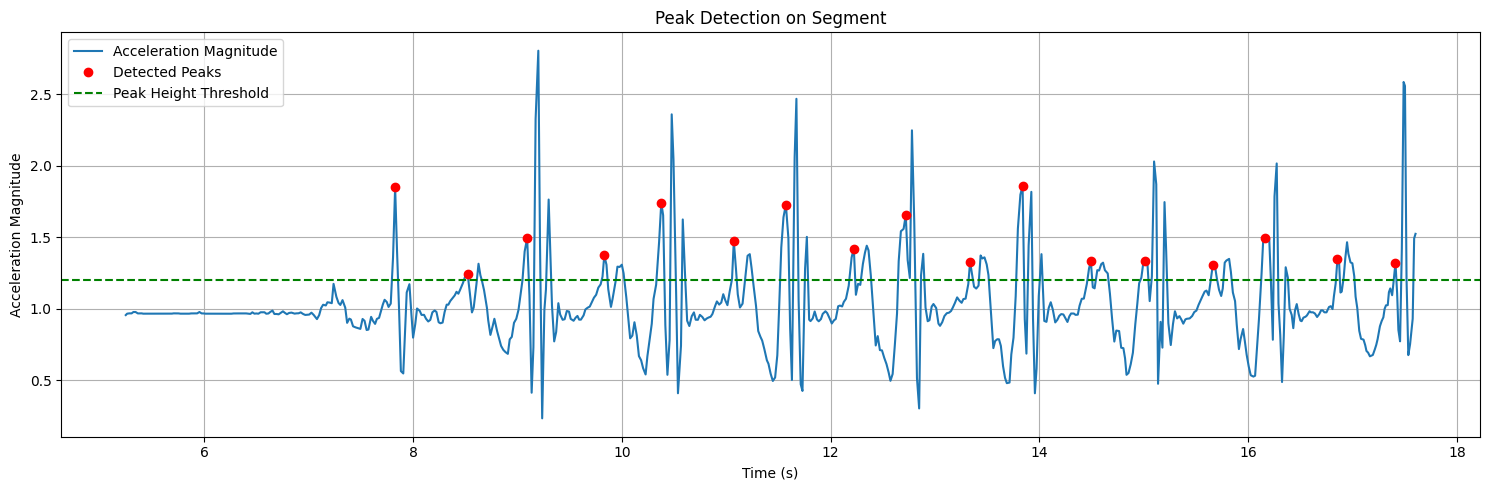

Walk segment index range: 0 → 622
Detected end_steps (absolute index): [143 175 207 238 268 297 325 353 380 407 436 465 494 523 555 592 623]
Turning segment from 624 to 701
Angle change sum: 31.758250000000004


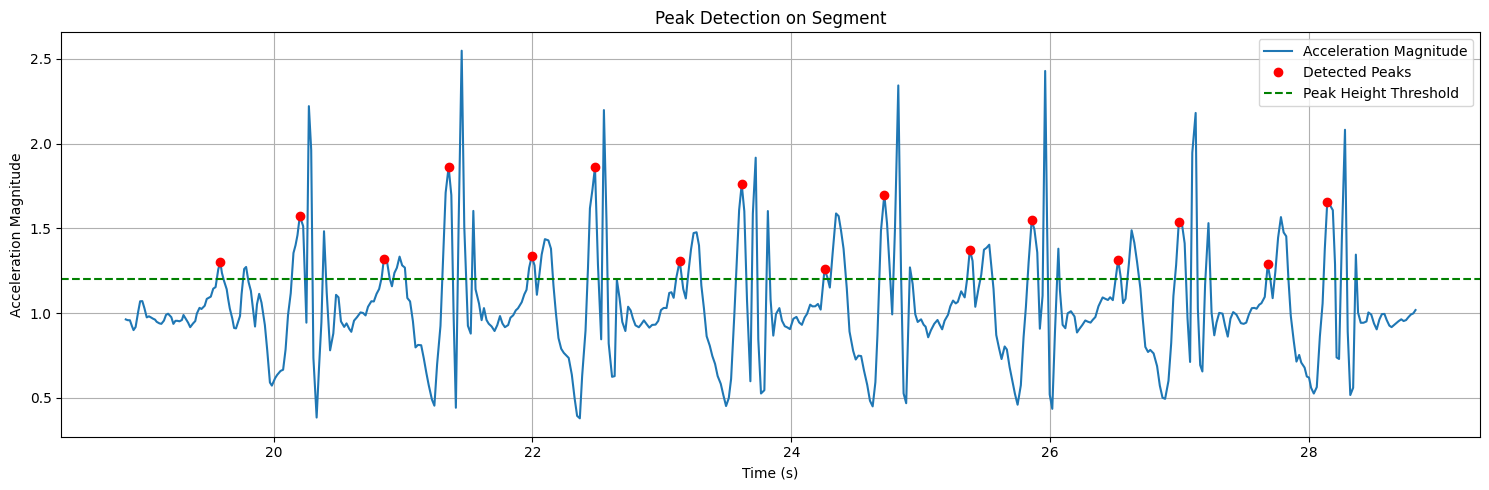

Walk segment index range: 702 → 1187
Detected end_steps (absolute index): [ 761  793  821  848  876  903  930  955  980 1006 1033 1060 1087 1114
 1141 1188]
Turning segment from 1189 to 1281
Angle change sum: -39.897000000000006


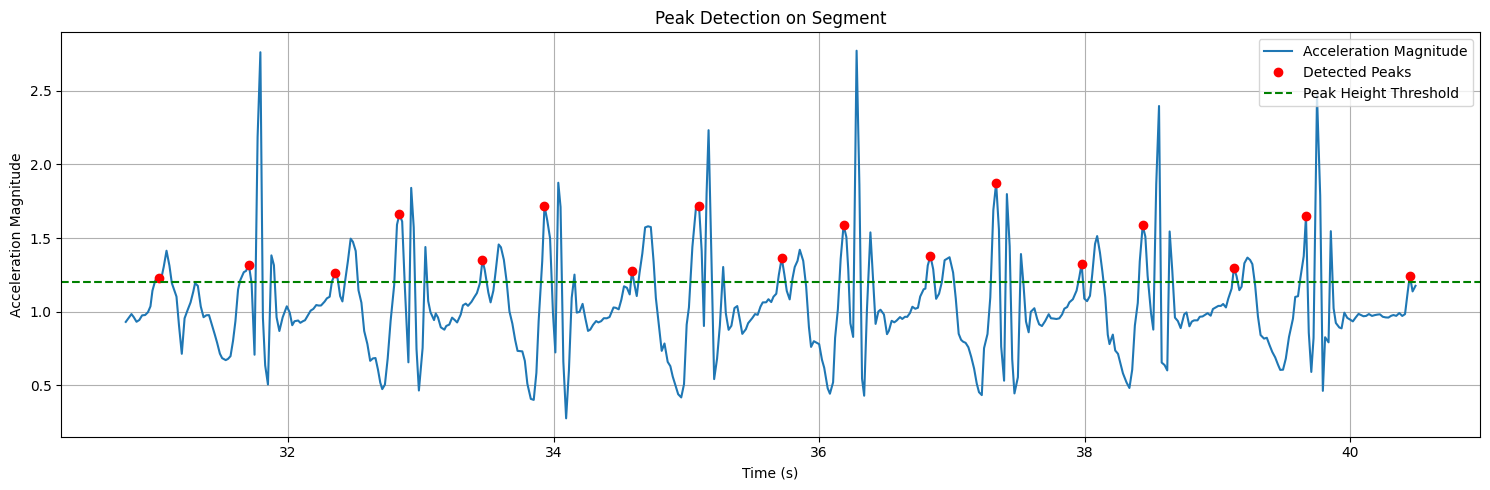

Walk segment index range: 1282 → 1755
Detected end_steps (absolute index): [1310 1342 1370 1397 1423 1451 1479 1506 1532 1560 1589 1616 1643 1672
 1702 1734 1756]
Turning segment from 1757 to 1849
Angle change sum: 50.46118


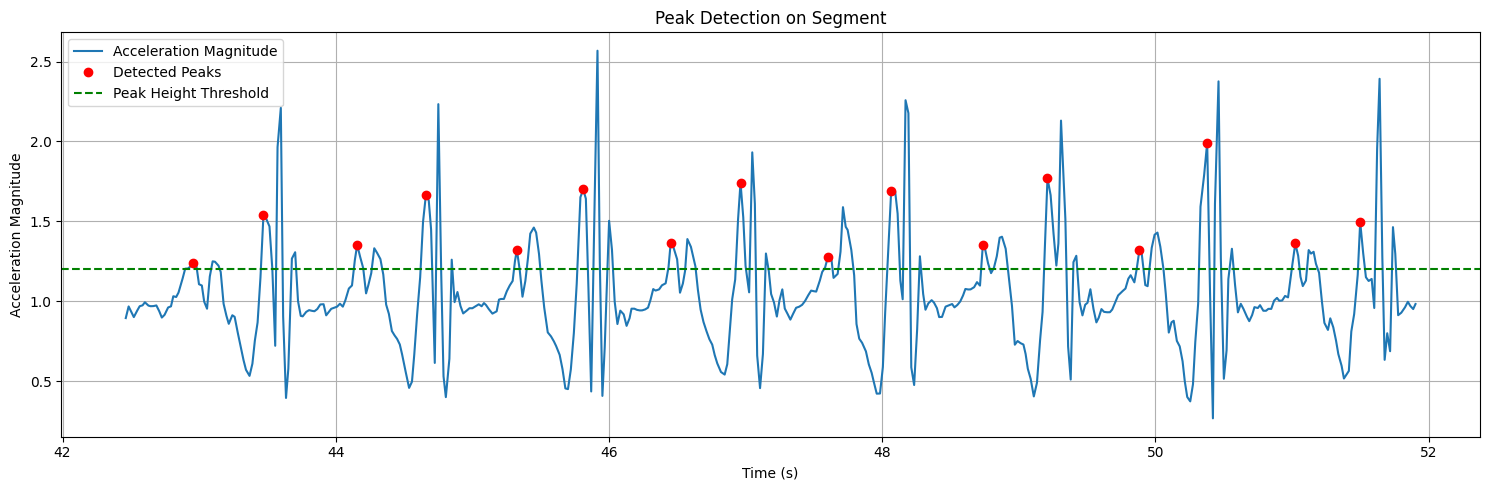

Walk segment index range: 1850 → 2304
Detected end_steps (absolute index): [1886 1915 1944 1972 1999 2026 2054 2081 2108 2135 2162 2190 2218 2245
 2272 2305]
Turning segment from 2306 to 2398
Angle change sum: 27.771460000000005


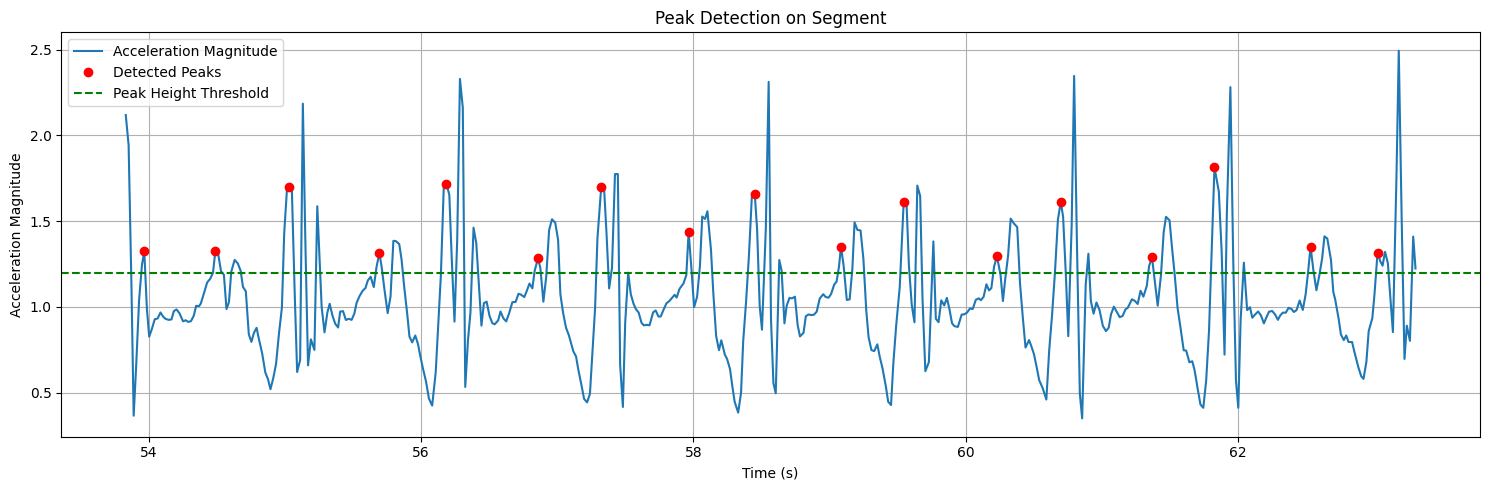

Walk segment index range: 2399 → 2861
Detected end_steps (absolute index): [2419 2445 2475 2503 2531 2559 2586 2614 2642 2669 2696 2724 2751 2778
 2806 2835 2862]
Turning segment from 2863 to 2940
Angle change sum: 28.56778


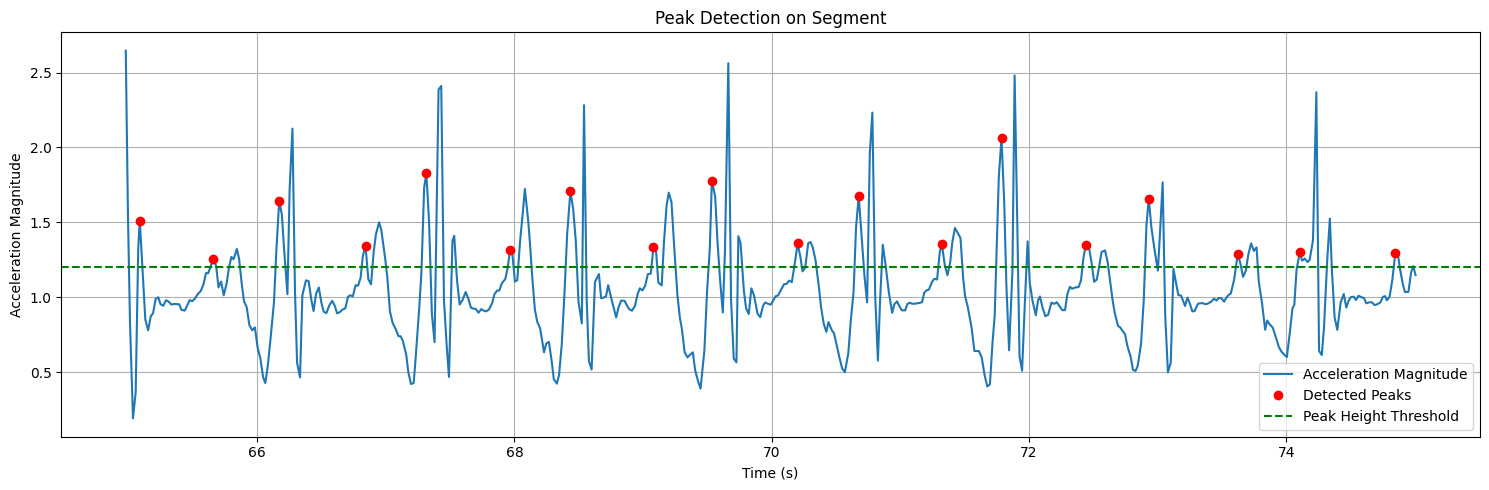

Walk segment index range: 2941 → 3428
Detected end_steps (absolute index): [2961 2987 3016 3044 3071 3098 3125 3152 3179 3206 3233 3260 3287 3315
 3343 3372 3402 3429]


In [15]:
def plot_peak_detection(df_segment, acc_magnitude, peaks, PEAK_HEIGHT, title="Peak Detection"):
    timestamps = df_segment['timestamp'].to_numpy() / 1000  # đổi ms → s

    plt.figure(figsize=(15, 5))
    plt.plot(timestamps, acc_magnitude, label='Acceleration Magnitude')
    plt.plot(timestamps[peaks], acc_magnitude[peaks], 'ro', label='Detected Peaks')
    plt.axhline(PEAK_HEIGHT, color='g', linestyle='--', label='Peak Height Threshold')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration Magnitude')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def detect_peaks(df, feature='gyro_y', vis=False):
    PEAK_HEIGHT = 1.2
    PEAK_DISTANCE = 14

    peaks = []
    last_peak_idx = -PEAK_DISTANCE

    acc_magnitude = df['acc_magnitude'].to_numpy()

    for i in range(1, len(acc_magnitude) - 1):
        if (
            acc_magnitude[i] > PEAK_HEIGHT and
            acc_magnitude[i] > acc_magnitude[i - 1] and
            acc_magnitude[i] > acc_magnitude[i + 1] and
            (i - last_peak_idx) >= PEAK_DISTANCE
        ):
            peaks.append(i)
            last_peak_idx = i

    peaks = np.array(peaks)

    if vis:
        plot_peak_detection(df, acc_magnitude, peaks, PEAK_HEIGHT, title="Peak Detection on Segment")

    if len(peaks) < 2:
        print("Not enough peaks detected.")
        return np.array([])

    return peaks

# --- Main segment processing ---
start_index = 0
last_start_index = 0
gyro_y = df['gyro_y'].to_numpy()
timestamp = df['timestamp'].to_numpy()
dt = np.diff(timestamp, prepend=timestamp[0]) / 1000.0  # ms → s
delta_yaw = gyro_y * dt

turn_degree = []

for segment in segment_data:
    if segment['type'] == 'walk':
        df_segment = df.iloc[segment['start_index']:segment['end_index']]
        peaks = detect_peaks(df_segment, feature='gyro_y', vis=True)

        # Chuyển index peak từ tương đối (trong segment) → tuyệt đối (trong df gốc)
        absolute_peaks = df_segment.index[peaks]

        # Tính end_steps theo index tuyệt đối
        end_steps = (absolute_peaks[:-1].to_numpy() + absolute_peaks[1:].to_numpy()) // 2
        end_steps = np.append(end_steps, segment['end_index'])

        print(f"Walk segment index range: {df_segment.index[0]} → {df_segment.index[-1]}")
        print("Detected end_steps (absolute index):", end_steps)

    elif segment['type'] == 'turn':
        print(f"Turning segment from {segment['start_index']} to {segment['end_index']}")
        print("Angle change sum:", np.sum(delta_yaw[segment['start_index']-20:segment['end_index']+30]))
        turn_degree.append(np.sum(delta_yaw[segment['start_index']:segment['end_index']]))


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

MAP_WIDTH_M = 20
MAP_HEIGHT_M = 20
initial_pos = np.array([8.9, 14.9])
initial_angle = -np.pi / 2
STEP_LENGTH_M = 0.58

NUM_PARTICLES = 200
PROCESS_NOISE = 0.05
MEASUREMENT_STD = 0.3

os.makedirs("result_filter", exist_ok=True)

def detect_peaks(df, vis=False):
    PEAK_HEIGHT = 1.05
    PEAK_DISTANCE = 14
    acc_magnitude = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2).to_numpy()
    peaks = []
    last_peak_idx = -PEAK_DISTANCE
    for i in range(1, len(acc_magnitude) - 1):
        if (
            acc_magnitude[i] > PEAK_HEIGHT and
            acc_magnitude[i] > acc_magnitude[i - 1] and
            acc_magnitude[i] > acc_magnitude[i + 1] and
            (i - last_peak_idx) >= PEAK_DISTANCE
        ):
            peaks.append(i)
            last_peak_idx = i
    return np.array(peaks)

# THE CODE BELOW GENERATED BY CHATGPT
def initialize_particles():
    particles = np.zeros((NUM_PARTICLES, 3))  # [x, y, angle]
    particles[:, :2] = initial_pos + np.random.normal(0, 0.1, (NUM_PARTICLES, 2))
    particles[:, 2] = initial_angle + np.random.normal(0, 0.1, NUM_PARTICLES)
    weights = np.ones(NUM_PARTICLES) / NUM_PARTICLES
    return particles, weights

def predict_particles(particles, step_length, delta_yaw):
    noise = np.random.normal(0, PROCESS_NOISE, (NUM_PARTICLES, 3))
    particles[:, 0] += step_length * np.cos(particles[:, 2]) + noise[:, 0]
    particles[:, 1] += step_length * np.sin(particles[:, 2]) + noise[:, 1]
    particles[:, 2] += delta_yaw + noise[:, 2]
    return particles

def update_weights(particles, measurement_pos):
    dists = np.linalg.norm(particles[:, :2] - measurement_pos, axis=1)
    weights = np.exp(-0.5 * (dists / MEASUREMENT_STD)**2)
    weights += 1e-300
    weights /= np.sum(weights)
    return weights

def resample_particles(particles, weights):
    indices = np.random.choice(NUM_PARTICLES, NUM_PARTICLES, p=weights)
    return particles[indices], np.ones(NUM_PARTICLES) / NUM_PARTICLES

def estimate_position(particles, weights):
    mean_pos = np.average(particles[:, :2], weights=weights, axis=0)
    mean_angle = np.arctan2(
        np.average(np.sin(particles[:, 2]), weights=weights),
        np.average(np.cos(particles[:, 2]), weights=weights)
    )
    return mean_pos, mean_angle

# === Main simulation function ===
def run_simulation(df, segment_data, delta_yaw, turn_degree):
    particles, weights = initialize_particles()
    path = [np.copy(initial_pos)]
    current_pos = np.copy(initial_pos)
    current_angle = initial_angle
    step_id = 0
    turn_count = 0
    
    bg_img = mpimg.imread("map_DC.png") # 800x800 pixel

    for segment in segment_data:
        start_idx = segment['start_index']
        end_idx = segment['end_index']

        if segment['type'] == 'walk':
            df_segment = df.iloc[start_idx:end_idx + 1]
            peaks = detect_peaks(df_segment)

            if len(peaks) == 0:
                continue

            absolute_peaks = peaks + start_idx
            for i in range(len(absolute_peaks)):
                yaw_change_start = absolute_peaks[i - 1] if i > 0 else start_idx
                yaw_change_end = absolute_peaks[i]
                total_yaw_change = np.sum(delta_yaw[yaw_change_start:yaw_change_end])

                # Ground truth position update (for simulated measurement)
                current_angle += total_yaw_change
                current_pos[0] += STEP_LENGTH_M * np.cos(current_angle)
                current_pos[1] += STEP_LENGTH_M * np.sin(current_angle)

                # Particle Filter update
                particles = predict_particles(particles, STEP_LENGTH_M, total_yaw_change)
                weights = update_weights(particles, current_pos)
                particles, weights = resample_particles(particles, weights)
                est_pos, est_angle = estimate_position(particles, weights)
                path.append(est_pos)

                # Plotting
                fig, ax = plt.subplots(figsize=(MAP_WIDTH_M, MAP_HEIGHT_M))
                ax.imshow(bg_img, extent=[0, MAP_WIDTH_M, 0, MAP_HEIGHT_M], origin='upper')
                ax.set_xlim(0, MAP_WIDTH_M)
                ax.set_ylim(0, MAP_HEIGHT_M)
                ax.set_aspect('equal')
                ax.grid(True)
                ax.set_title(f"Step {step_id} - Walk")
                ax.plot(*zip(*path), 'b-', label="Estimated Path")
                ax.plot(path[0][0], path[0][1], 'go', label="Start")
                ax.plot(est_pos[0], est_pos[1], 'rx', label="Estimate")
                ax.scatter(particles[:, 0], particles[:, 1], s=1, alpha=0.3, label="Particles")
                ax.arrow(est_pos[0], est_pos[1], 0.5 * np.cos(est_angle), 0.5 * np.sin(est_angle),
                         head_width=0.25, head_length=0.3, fc='r', ec='r')
                ax.legend()
                plt.tight_layout()
                plt.savefig(f"result_filter/step_{step_id:03d}.png")
                plt.close()
                print(f"result_filter/step_{step_id:03d}.png")
                step_id += 1

        elif segment['type'] == 'turn':
            # Tùy chỉnh góc quay thủ công (ví dụ: ±90 độ nhân hệ số)
            delta_angle_rad = np.deg2rad(turn_degree[turn_count])
            particles[:, 2] -= delta_angle_rad 
            current_angle -= delta_angle_rad 
            turn_count += 1

            est_pos, est_angle = estimate_position(particles, weights)
            path.append(est_pos)

            # Plot turn
            fig, ax = plt.subplots(figsize=(MAP_HEIGHT_M, MAP_HEIGHT_M))
            ax.imshow(bg_img, extent=[0, MAP_WIDTH_M, 0, MAP_HEIGHT_M], origin='upper')
            ax.set_xlim(0, MAP_WIDTH_M)
            ax.set_ylim(0, MAP_HEIGHT_M)
            ax.set_aspect('equal')
            ax.grid(True)
            ax.set_title(f"Step {step_id} - Turn")
            ax.plot(*zip(*path), 'b-', label="Estimated Path")
            ax.plot(path[0][0], path[0][1], 'go', label="Start")
            ax.plot(est_pos[0], est_pos[1], 'yo', label="Turn")
            ax.scatter(particles[:, 0], particles[:, 1], s=1, alpha=0.3, label="Particles")
            ax.arrow(est_pos[0], est_pos[1], 0.5 * np.cos(est_angle), 0.5 * np.sin(est_angle),
                     head_width=0.25, head_length=0.3, fc='r', ec='r')
            ax.legend()
            plt.tight_layout()
            plt.savefig(f"result_filter/step_{step_id:03d}.png")
            plt.close()
            print(f"result_filter/step_{step_id:03d}.png")
            step_id += 1
    
    path = np.array(path)

    # === Plot ===
    plt.figure(figsize=(MAP_WIDTH_M, MAP_HEIGHT_M))
    ax = plt.gca()
    ax.imshow(bg_img, extent=[0, MAP_WIDTH_M, 0, MAP_HEIGHT_M], origin='upper')
    ax.plot(path[:, 0], path[:, 1], 'b-', label="Estimated Path")
    ax.plot(path[0, 0], path[0, 1], 'go', label="Start")
    ax.plot(path[-1, 0], path[-1, 1], 'rx', label="End")
    ax.arrow(path[-1, 0], path[-1, 1],
            0.5 * np.cos(est_angle), 0.5 * np.sin(est_angle),
            head_width=0.2, head_length=0.3, fc='r', ec='r')

    ax.set_xlim(0, MAP_WIDTH_M)
    ax.set_ylim(0, MAP_HEIGHT_M)
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_title("Đường đi ước lượng sau Particle Filter")
    plt.legend()
    plt.tight_layout()
    plt.savefig("final_estimated_path.png")
    plt.show()



Because we couldn't estimate the turning angle of the TURNING PERIOD,   
so we have to asign turn_degree manually

result_filter/step_000.png
result_filter/step_001.png
result_filter/step_002.png
result_filter/step_003.png
result_filter/step_004.png
result_filter/step_005.png
result_filter/step_006.png
result_filter/step_007.png
result_filter/step_008.png
result_filter/step_009.png
result_filter/step_010.png
result_filter/step_011.png
result_filter/step_012.png
result_filter/step_013.png
result_filter/step_014.png
result_filter/step_015.png
result_filter/step_016.png
result_filter/step_017.png
result_filter/step_018.png
result_filter/step_019.png
result_filter/step_020.png
result_filter/step_021.png
result_filter/step_022.png
result_filter/step_023.png
result_filter/step_024.png
result_filter/step_025.png
result_filter/step_026.png
result_filter/step_027.png
result_filter/step_028.png
result_filter/step_029.png
result_filter/step_030.png
result_filter/step_031.png
result_filter/step_032.png
result_filter/step_033.png
result_filter/step_034.png
result_filter/step_035.png
result_filter/step_036.png
r

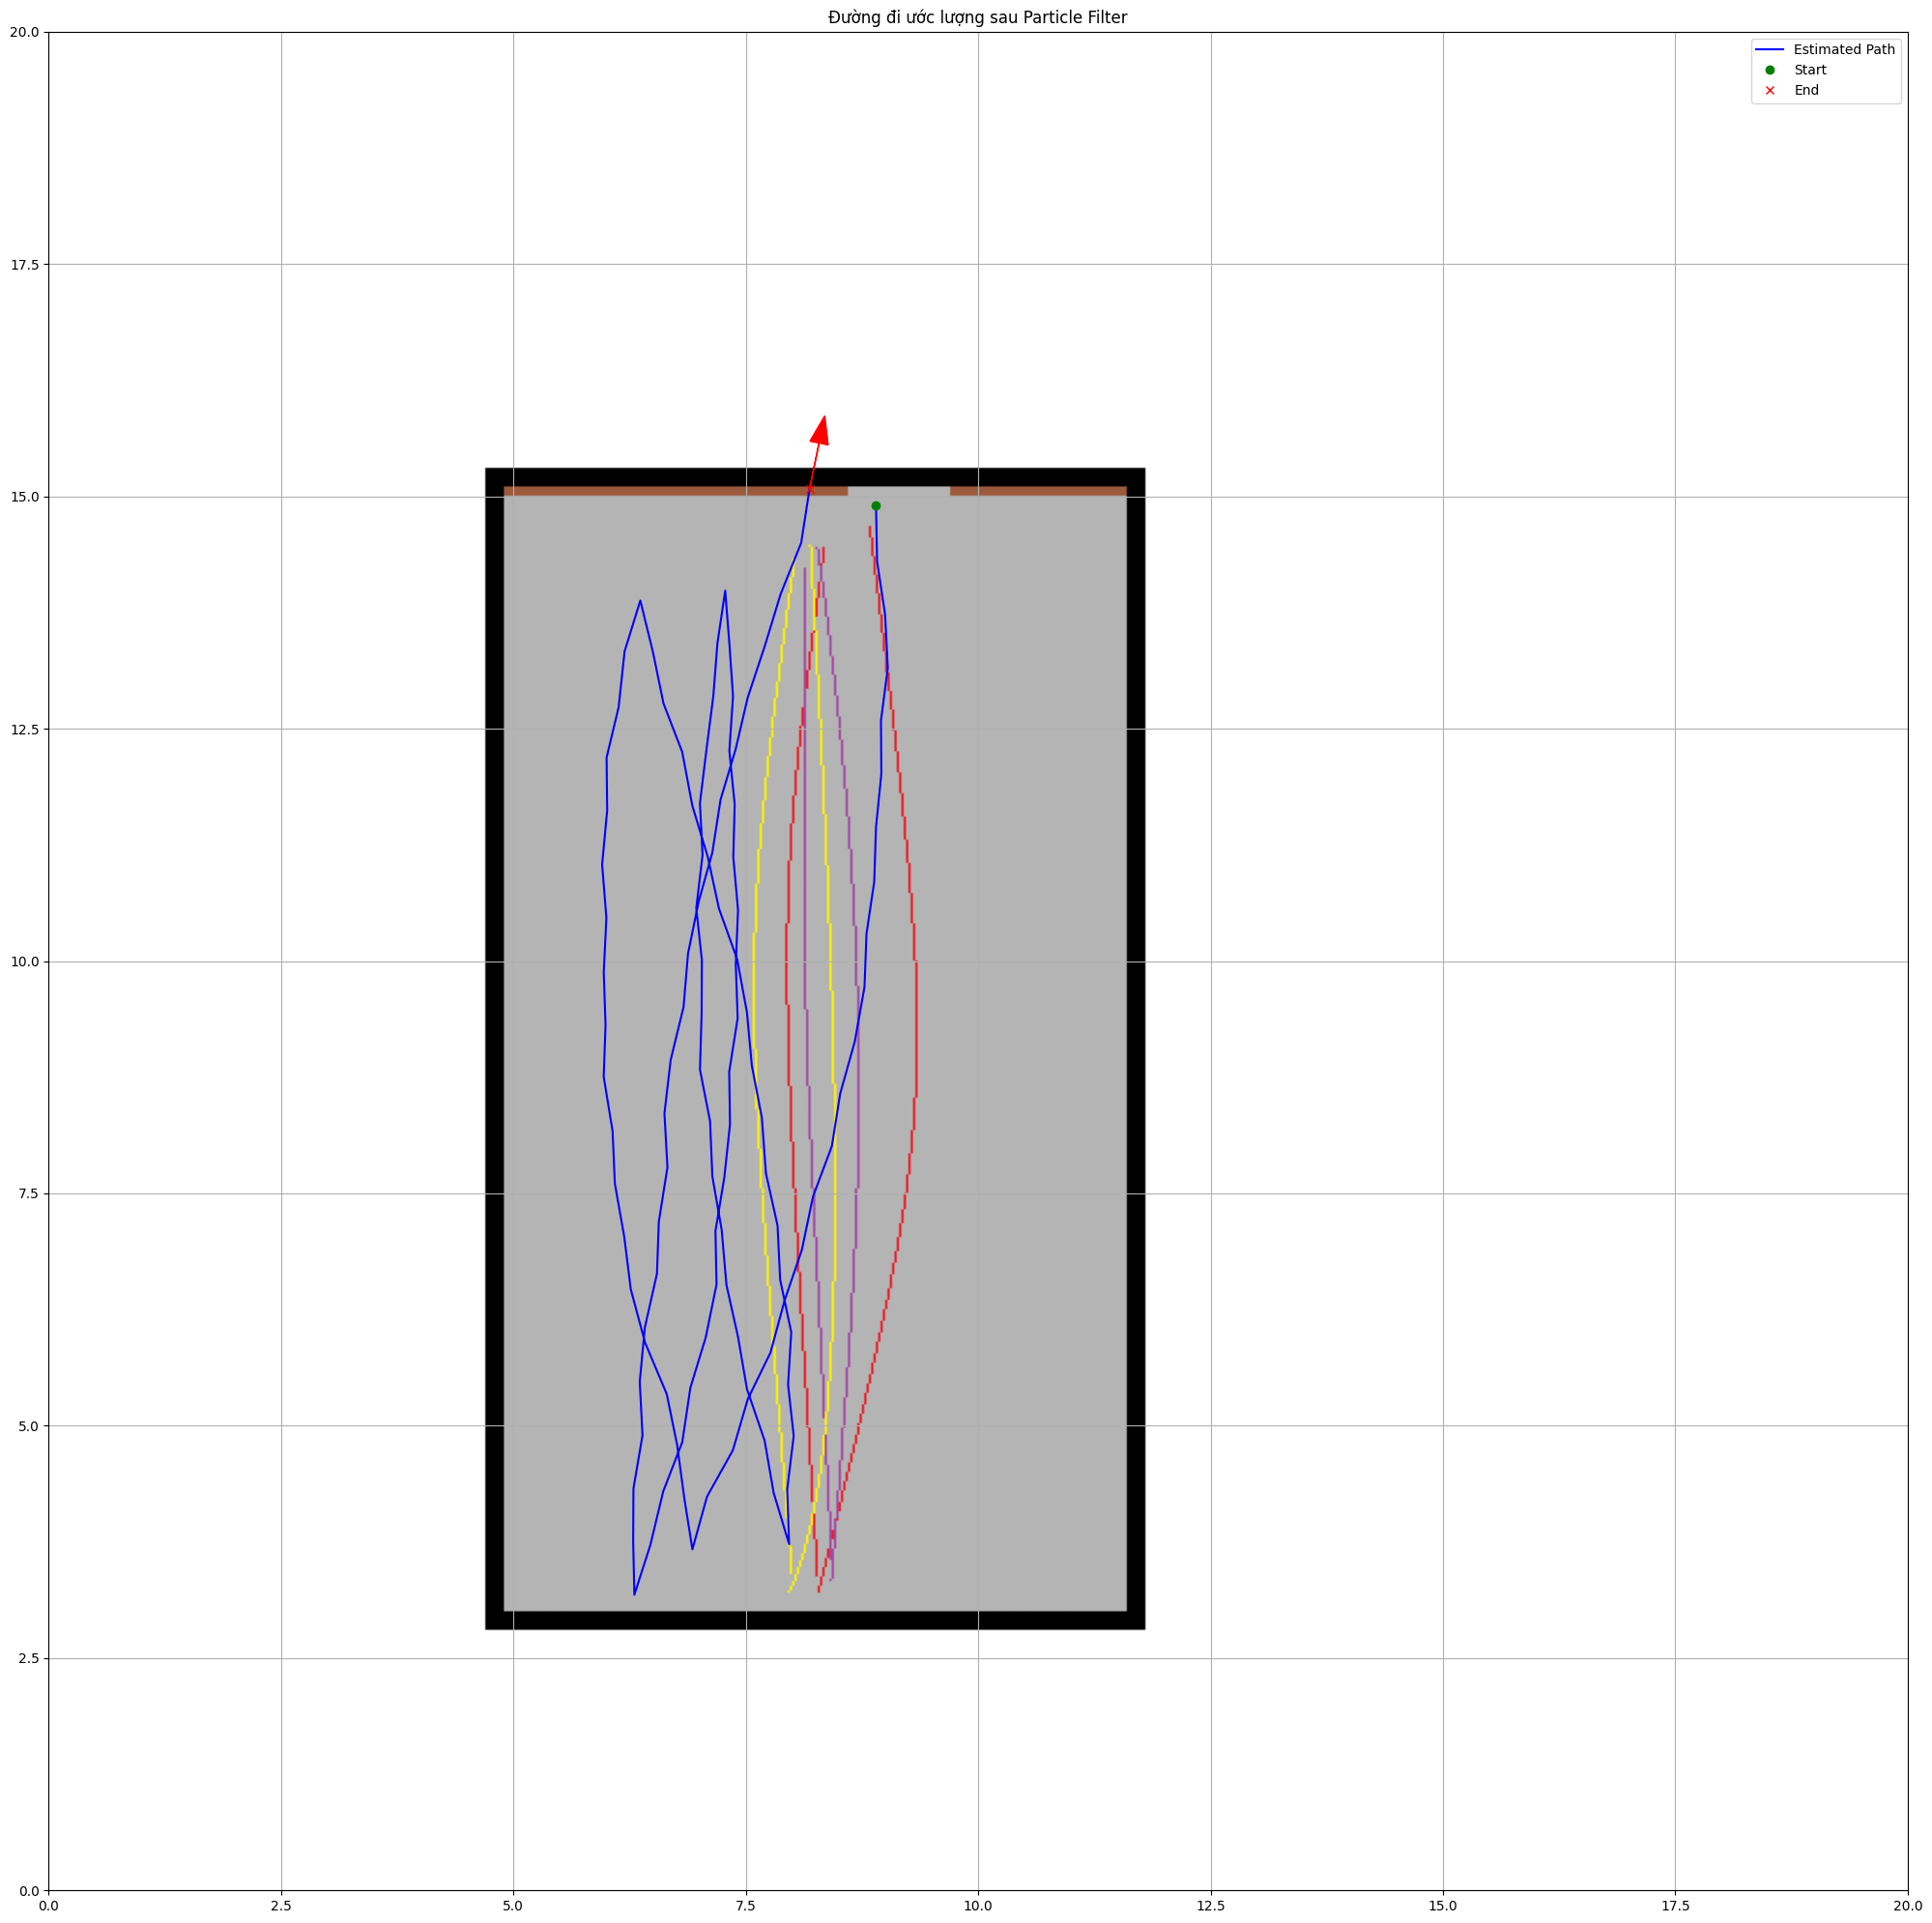

In [17]:
turn_degree = [150, -200, 160, 175,  168]
path = run_simulation(df, segment_data, np.deg2rad(delta_yaw), turn_degree)

# Evaluation and Reflection 

- The simulation video is saved as `result/output.mp4`
- Data collecting is very expensive and time comsuming. We've spent lot of time (~10h) to collect and test the data
- Maintaining a consistent Sampling rate is very important when processing time-series data
- With Step detection algorithm, we can easily estimate the position of the device after every step 
- Heading/Direction estimation is very challenging, especially when you don't have Magnetometer data

